<a id='introduction'></a>
# 0. Introduction

This notebook aims to show how to create a simple Handwriting Recognition (HWR) application, able to recognize both letters and numbers. For that, we are going to use two libraries fundamentally:
- `scikit-image`: for image processing.
- `scikit-learn`: to train our model.

The steps we will follow are:
- Looking for an appropriate dataset.
- Pre-processing the image with the handwritten text.
- Train our model with the chosen dataset.
- Test it out with out own samples.

<a id='emnist_dataset'></a>
# 1. EMNIST Dataset

For this example, we will use the EMNIST Dataset [[1]](#ref_1) which is "a set of handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset".  You can find more information about it [here](https://www.nist.gov/itl/products-and-services/emnist-dataset).

However, if you wish to use a different dataset, the process should be very similar to what we will follow here.

The EMNIST Dataset offers six different splits. In our case, we will use the "EMNIST Balanced" split, which contains 131,600 characters (letters and numbers) and 47 balanced classes. We can get it from [Kaggle](https://www.kaggle.com/crawford/emnist).

Once downloaded, let's load it with `pandas`.

In [5]:
import pandas as pd
from pathlib import Path

# read training and test datasets
train_data = pd.read_csv(Path("datasets/emnist-balanced-train.csv")).values
test_data = pd.read_csv(Path("datasets/emnist-balanced-test.csv")).values

The format of data is:
- The first column contains the labels (classes), which are a number from 0 to 46 (since there are 47 classes).
- The second column contains the image data. The images are in black and white. Each value corresponds to a pixel and can range from 0 (completely black) to 255 (completely white). The data is stored in one dimension.

---

| Class | Image data |
| --- | --- |
| 4 | [ 0 0 254 214 ... 214 154 45 0 0 ] |
| 21 | [ 188 0 0 179 ... 245 70 244 0 0 ] |
| 8 | [ 0 45 177 89 ...  80 154 90 0 45 ] |
| 11 | [ 0 252 196 200 ... 61 251 0 0 0 ] |
| **...** | **...** |

---

Let's separate the input from the target values:

In [6]:
# training set
x_train = train_data[...,1:] # all columns except the first
y_train = train_data[...,0] # first column

# test set
x_test = test_data[...,1:]
y_test = test_data[...,0]

We can now plot one of the images to check that everything is working fine. We'll use `matplotlib` for that.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

The image data, as we have mentioned previously, is stored in only one dimension. In addition, the images are mirrored horizontally and rotated 90º. Because of this, we cannot plot them directly. First, we need to take the following steps:
- Change the shape of the image so that it has two dimensions. To do this we will use numpy's `shape()` function. The images size is 28 x 28 pixels, so we will pass these values to that function.
- Mirror the image horizontally. Numpy provides the function `fliplr()`for that.
- Rotate it 90º, with the function `rot90()`, also from numpy.

In [11]:
import numpy as np

def imshow_EMNIST(img):
    '''Plots EMNIST dataset images.

    Args:
        img:
            EMNIST image.
    '''
    
    img.shape = (28, 28) # make the image two-dimensional (28x28 pixels)
    img = np.fliplr(img) # flip it horizontally
    img = np.rot90(img) # rotate it 90º
    plt.imshow(255-img, cmap='gray') # invert the image, so black pixels are 
                                     # white and viceversa, also plot it in
                                     # grayscale (cmap='gray')

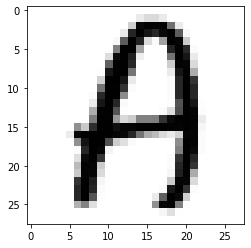

In [14]:
img = x_test[1100] # random image
imshow_EMNIST(img)

As we said before, the labels will take values between 0 and 46. The correspondence between the labels and the characters is as follows:

| Label | Character |
| --- | --- |
| 0 | '0' |
| **...** | **...** |
| 9 | '9' |
| 10 | 'A' |
| **...** | **...** |
| 35 | 'Z' |
| 36 | 'a' |
| **...** | **...** |
| 46 | 't' |

---

We might think that the conversion of the label into ASCII code would be as simple as carrying out an addition. For example, the label for 'A' is 10, and its ASCII code is 65. So, adding 55 to the label would be enough to get the character.

However, that's quite not right, since there are characters that share the same label, as we can see in the following image extracted from the [EMNIST paper](https://arxiv.org/pdf/1702.05373v1.pdf):

<img src="./images_notebook/EMNIST_dataset.jpg" alt="Balanced EMNSIT Dataset" width="800" align="left" />

This is due to the similarity of certain lowercase and uppercase letters. For example, the characters 'o' and 'O', 'x' and 'X', 'w' and 'W', etc. Telling whether they are lower or uppercase in an isolated context is very complicated, if not impossible.

To establish the correspondence label-character, due to the small irregularities mentioned, the simplest thing to do might be defining a dictionary.

In [15]:
# label-character correspondence
data2ascii = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
              10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
              19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
              28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a',
              37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r',
              46: 't'}

Using the previous example...

Character: A


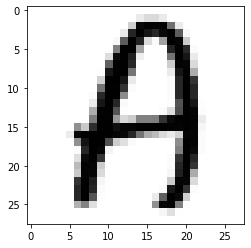

In [18]:
imshow_EMNIST(img)
print("Character:", data2ascii[y_test[1100]]) # y_test stores the labels

It would also be interesting to implement a function that would allow us to find all the occurrences of a certain character in the dataset.

In [22]:
def find_character(character, label_set):
    '''Finds a specific character in a set.

    Args:
        character:
            Character to look for.
        label_set:
            Set containing EMNIST labels.
    
    Returns:
        Indexes where the character has been found.
    '''
    
    pos = []
    for i in range(len(label_set)):
        if data2ascii[label_set[i]] == character:
            pos.append(i)
    return pos

For example, let's look for all the occurrences of 'C':

Number of 'C' characters: 400
[8, 29, 34, 37, 83, 95, 141, 147, 150, 227, 236, 337, 493, 584, 629, 633, 762, 768, 807, 809]


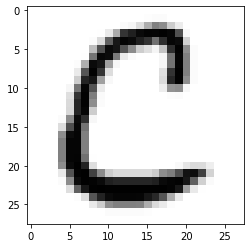

In [26]:
indexes = find_character('C', y_test)

print("Number of 'C' characters:", len(indexes))
print(indexes[:20])

imshow_EMNIST(x_test[indexes[2]]) # third 'C' character in the dataset

---

[WIP}

<a id='bibliography'></a>
# #. Bibliography

<a id='ref_1'>[1]</a> Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373.